In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras import metrics
from config import myNet
from conv_net import utils
import numpy as np
from conv_net.var_autoencoder import variational_encoder
from plot import Plot

from plot import Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

Using TensorFlow backend.


Input your image type OPTIONS: (assessor, assessor_code, google_aerial, google_overlayed 
 IMAGE_TYPE = assessor_code


## LOAD MNIST DATA

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[np.where((y_train==6) | (y_train == 8))[0]]
y_train = y_train[np.where((y_train==6) | (y_train == 8))[0]]
x_train, y_train = utils.unison_shuffled_copies(x_train, y_train)

x_test = x_test[np.where((y_test==6) | (y_test == 8))[0]]
y_test = y_test[np.where((y_test==6) | (y_test == 8))[0]]



x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print (x_train.shape)
print (x_test.shape)

(11769, 784)
(1932, 784)


In [3]:
def RUN(epochs, batch_size, x_train, x_test, y_test):
    tf.reset_default_graph()


    computation_graph = variational_encoder()
    test_loss = []
    training_loss = []
    test_accuracy = []
    learning_rate = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_batches = len(x_train)//batch_size + 1

        for epoch in range(0,epochs):
            tr_loss = []
            for batch_num in range(0,num_batches):
                if batch_num != (num_batches - 1):
                    from_idx = batch_num * batch_size
                    to_idx = (batch_num * batch_size) + batch_size
                else:
                    from_idx = batch_num * batch_size
                    to_idx = (batch_num * batch_size) + (len(x_train) - (batch_num * batch_size))
                # print (x_train[from_idx:to_idx].shape)
                feed_dict = {computation_graph['inpX']:x_train[from_idx:to_idx]}
                tr_ls, _, lrate  = sess.run([computation_graph['loss'], computation_graph['optimizer'], computation_graph['learning_rate']], feed_dict=feed_dict)
                tr_loss.append(tr_ls)
                training_loss.append(tr_ls)
                learning_rate.append(lrate)

            feed_dict = {computation_graph['inpX']: x_test}
            l_features, ts_ls = sess.run([computation_graph['latent_features'], computation_graph['loss']],
                                               feed_dict=feed_dict)
            test_loss.append(ts_ls)
            score = 0
            tot = 2
            rand_state = [223,431]
            for i in range(0,tot):
                from sklearn.cluster import KMeans

                kmeans = KMeans(n_clusters=2, n_init=100, random_state=rand_state[i])
                kmeans = kmeans.fit(l_features)
                labels = kmeans.predict(l_features)
                centroids = kmeans.cluster_centers_

                labels[labels == 0] = 6
                labels[labels == 1] = 8

                from conv_net.utils import Score
                scr = Score.accuracy(y_test, labels)
                score += max(scr, 1-scr)
            
            test_accuracy.append(score/tot)

            if (epoch%10)  == 0:
                print ('EPOCH = %s, Avg Train Loss = %s, Test Loss = %s, Cluster_accuracy = %s'%(str(epoch), str(np.sum(tr_loss)/len(tr_loss)), str(ts_ls), score/tot))
    return training_loss, test_loss, test_accuracy, learning_rate

## MODEL 1: Two Fully connected layers [256, 128], learnin_rate = 0.001

We can see some amount of overfitting

In [4]:
epochs = 50
batch_size = 128
training_loss, test_loss, test_accuracy = RUN(epochs, batch_size,x_train, x_test, y_test)

X1:  (?, 256)
X1:  (?, 128)
z_mean:  (?, 32)
z_log_var:  (?, 32)
latent encoder:  (?, 32)
latent decoder:  (?, 128)
latent decoder:  (?, 256)
X_decoded_mean:  (?, 784)
input_shape (?, 784)
12121212121212 ()
Learning Rate: Initial:  0.001
EPOCH = 0, Avg Train Loss = 560.339334239, Test Loss = 536.448, Cluster_accuracy = 0.896997929607
EPOCH = 10, Avg Train Loss = 523.817934783, Test Loss = 521.022, Cluster_accuracy = 0.910196687371
EPOCH = 20, Avg Train Loss = 523.526197351, Test Loss = 521.001, Cluster_accuracy = 0.913043478261
EPOCH = 30, Avg Train Loss = 524.48607337, Test Loss = 521.851, Cluster_accuracy = 0.931677018634
EPOCH = 40, Avg Train Loss = 525.023862092, Test Loss = 522.179, Cluster_accuracy = 0.92701863354


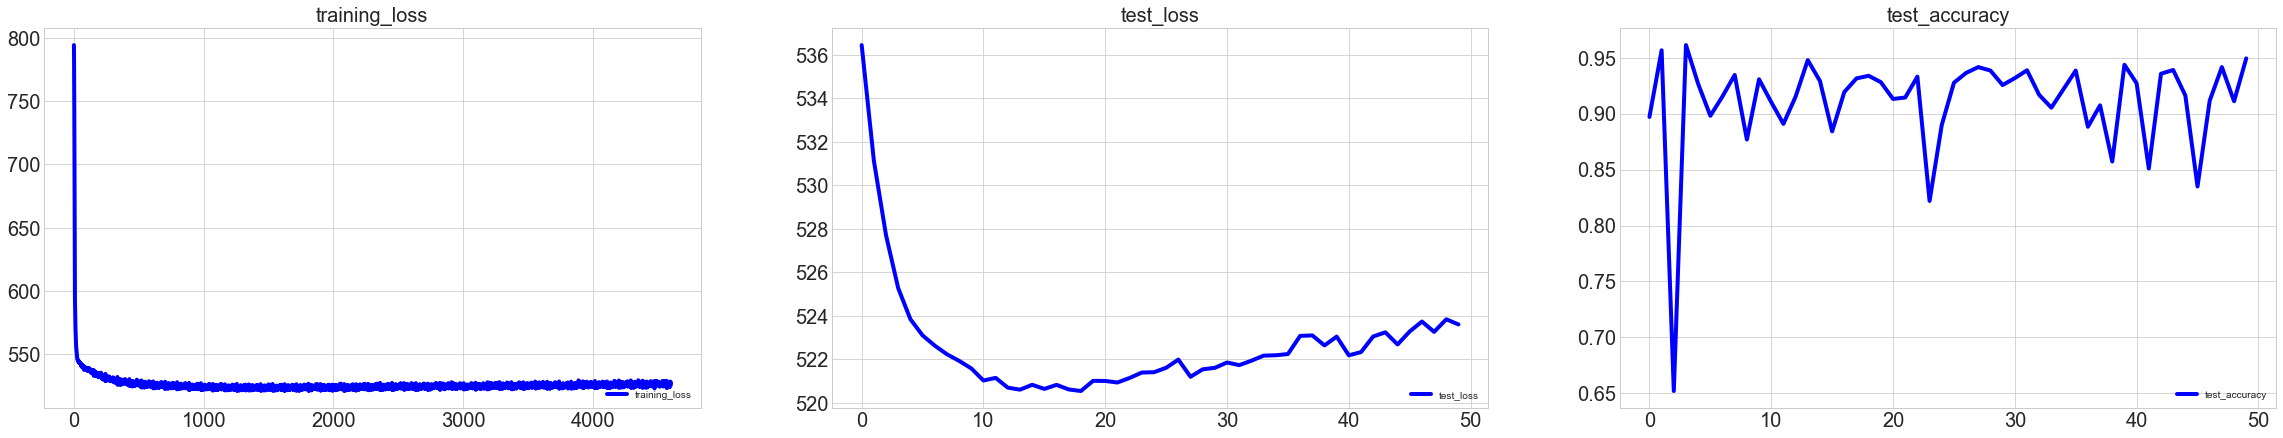

In [5]:
oj = Plot(rows=1, columns=3, fig_size=(40,7))

l_rate_df = pd.DataFrame(training_loss, columns=['training_loss'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'training_loss'})

tr_loss_df = pd.DataFrame(test_loss, columns=['test_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_loss'})

cv_loss_df = pd.DataFrame(test_accuracy, columns=['test_accuracy'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_accuracy'})

## MODEL 2 = MDOEL 1 + Batch normalization

So sign of overfitting, but early stopping would be much better (at epoch 30)

In [4]:
epochs = 50
batch_size = 128
training_loss, test_loss, test_accuracy = RUN(epochs, batch_size,x_train, x_test, y_test)

X1:  (?, 256)
X1:  (?, 128)
z_mean:  (?, 32)
z_log_var:  (?, 32)
latent encoder:  (?, 32)
latent decoder:  (?, 128)
latent decoder:  (?, 256)
X_decoded_mean:  (?, 784)
input_shape (?, 784)
12121212121212 ()
Learning Rate: Initial:  0.001
EPOCH = 0, Avg Train Loss = 605.331946332, Test Loss = 530.895, Cluster_accuracy = 0.921842650104
EPOCH = 10, Avg Train Loss = 520.672809103, Test Loss = 518.143, Cluster_accuracy = 0.944099378882
EPOCH = 20, Avg Train Loss = 519.746051291, Test Loss = 517.487, Cluster_accuracy = 0.96350931677
EPOCH = 30, Avg Train Loss = 519.339164402, Test Loss = 517.312, Cluster_accuracy = 0.966873706004
EPOCH = 40, Avg Train Loss = 519.048870584, Test Loss = 517.061, Cluster_accuracy = 0.959627329193


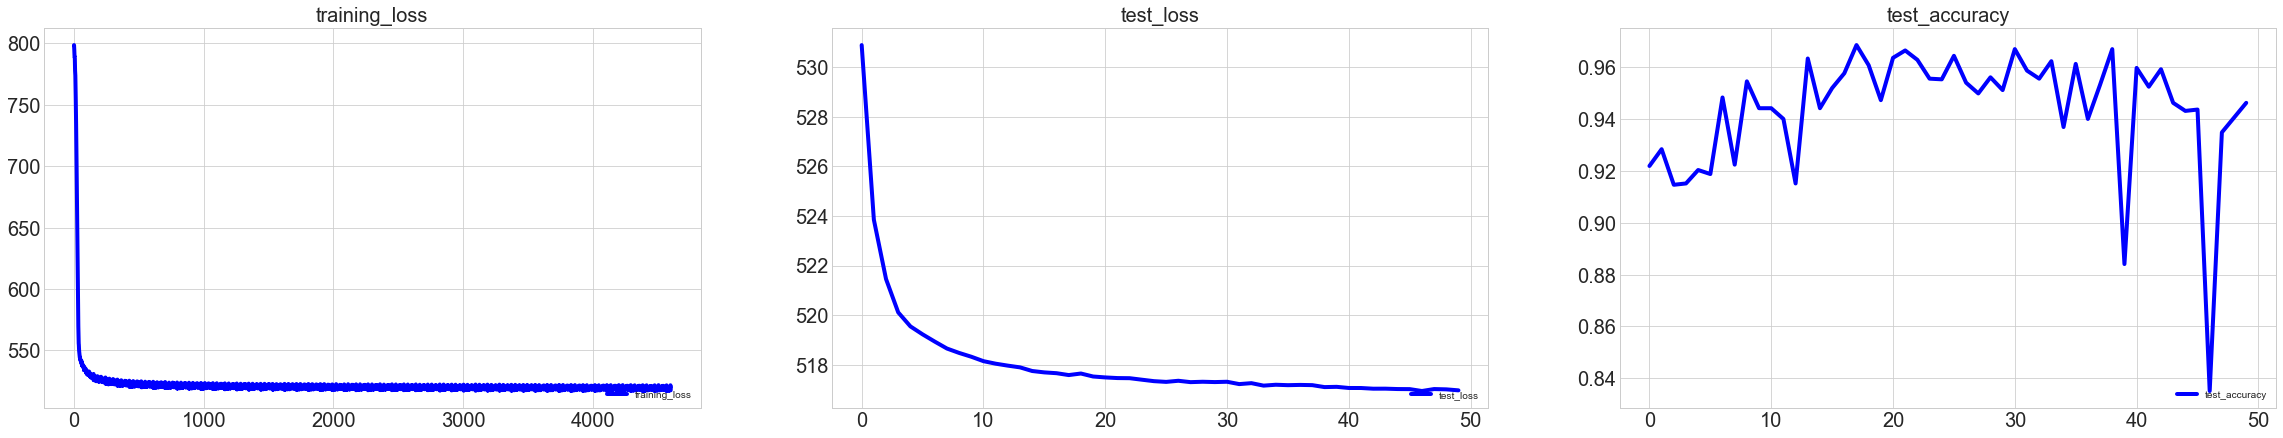

In [5]:
oj = Plot(rows=1, columns=3, fig_size=(40,7))

l_rate_df = pd.DataFrame(training_loss, columns=['training_loss'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'training_loss'})

tr_loss_df = pd.DataFrame(test_loss, columns=['test_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_loss'})

cv_loss_df = pd.DataFrame(test_accuracy, columns=['test_accuracy'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_accuracy'})

## MODEL 3 = MODEL 2 + learning_rate_decay

In [4]:
epochs = 50
batch_size = 128
training_loss, test_loss, test_accuracy, learning_rate = RUN(epochs, batch_size,x_train, x_test, y_test)

X1:  (?, 256)
X1:  (?, 128)
z_mean:  (?, 32)
z_log_var:  (?, 32)
latent encoder:  (?, 32)
latent decoder:  (?, 128)
latent decoder:  (?, 256)
X_decoded_mean:  (?, 784)
input_shape (?, 784)
12121212121212 ()
Learning Rate: Initial:  0.001
EPOCH = 0, Avg Train Loss = 605.303541101, Test Loss = 530.999, Cluster_accuracy = 0.92701863354
EPOCH = 10, Avg Train Loss = 520.423403533, Test Loss = 517.925, Cluster_accuracy = 0.951345755694
EPOCH = 20, Avg Train Loss = 519.469514266, Test Loss = 517.291, Cluster_accuracy = 0.928053830228
EPOCH = 30, Avg Train Loss = 519.036387568, Test Loss = 517.068, Cluster_accuracy = 0.92701863354
EPOCH = 40, Avg Train Loss = 518.764266304, Test Loss = 516.932, Cluster_accuracy = 0.922877846791


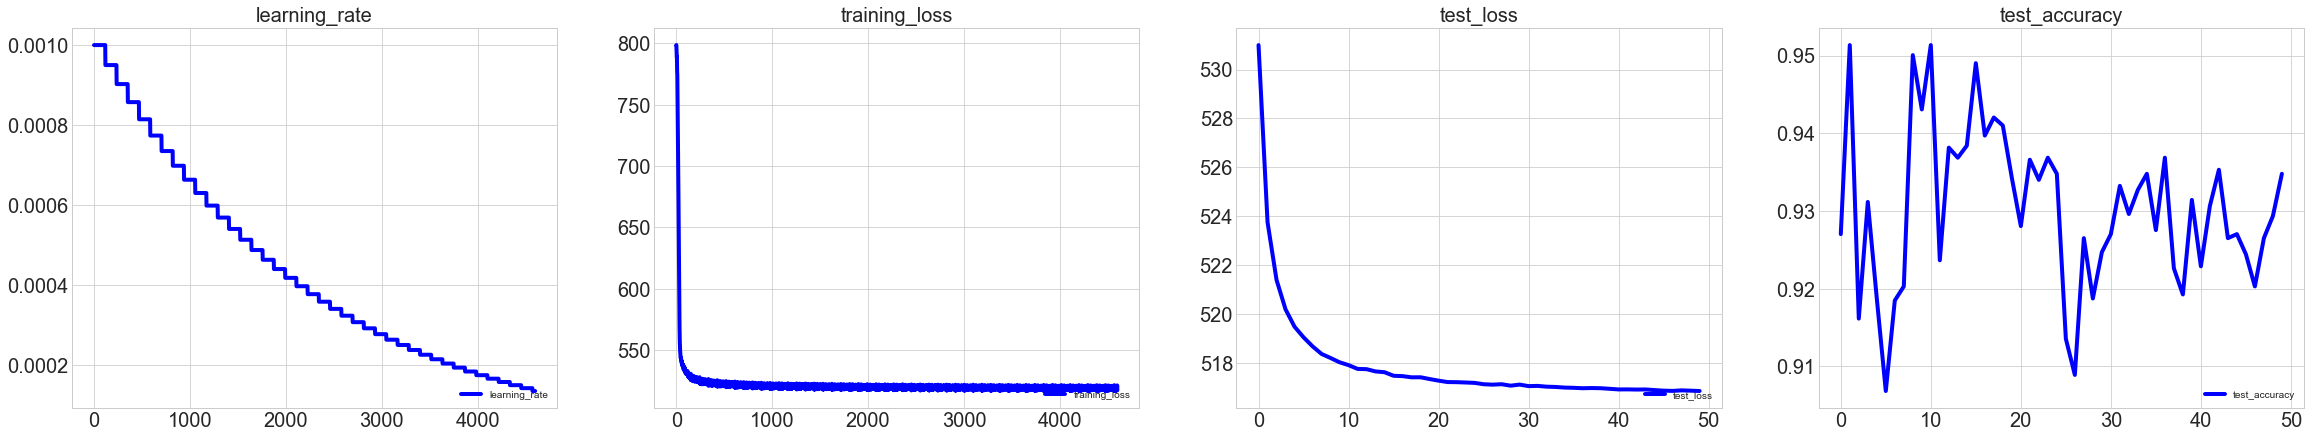

In [5]:
from plot import Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

oj = Plot(rows=1, columns=4, fig_size=(40,7))

l_rate_df = pd.DataFrame(learning_rate, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'learning_rate'})

l_rate_df = pd.DataFrame(training_loss, columns=['training_loss'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'training_loss'})

tr_loss_df = pd.DataFrame(test_loss, columns=['test_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_loss'})

cv_loss_df = pd.DataFrame(test_accuracy, columns=['test_accuracy'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_accuracy'})

## MODEL 4: MODEL 3 but leanring_rate = 0.01

In [4]:
epochs = 50
batch_size = 128
training_loss, test_loss, test_accuracy, learning_rate = RUN(epochs, batch_size,x_train, x_test, y_test)

X1:  (?, 256)
X1:  (?, 128)
z_mean:  (?, 32)
z_log_var:  (?, 32)
latent encoder:  (?, 32)
latent decoder:  (?, 128)
latent decoder:  (?, 256)
X_decoded_mean:  (?, 784)
input_shape (?, 784)
12121212121212 ()
Learning Rate: Initial:  0.01
EPOCH = 0, Avg Train Loss = 556.940726902, Test Loss = 529.18, Cluster_accuracy = 0.764492753623
EPOCH = 10, Avg Train Loss = 523.336319633, Test Loss = 520.637, Cluster_accuracy = 0.877329192547
EPOCH = 20, Avg Train Loss = 521.982336957, Test Loss = 519.533, Cluster_accuracy = 0.928571428571
EPOCH = 30, Avg Train Loss = 521.128693954, Test Loss = 518.855, Cluster_accuracy = 0.83566252588
EPOCH = 40, Avg Train Loss = 520.638586957, Test Loss = 518.565, Cluster_accuracy = 0.870600414079


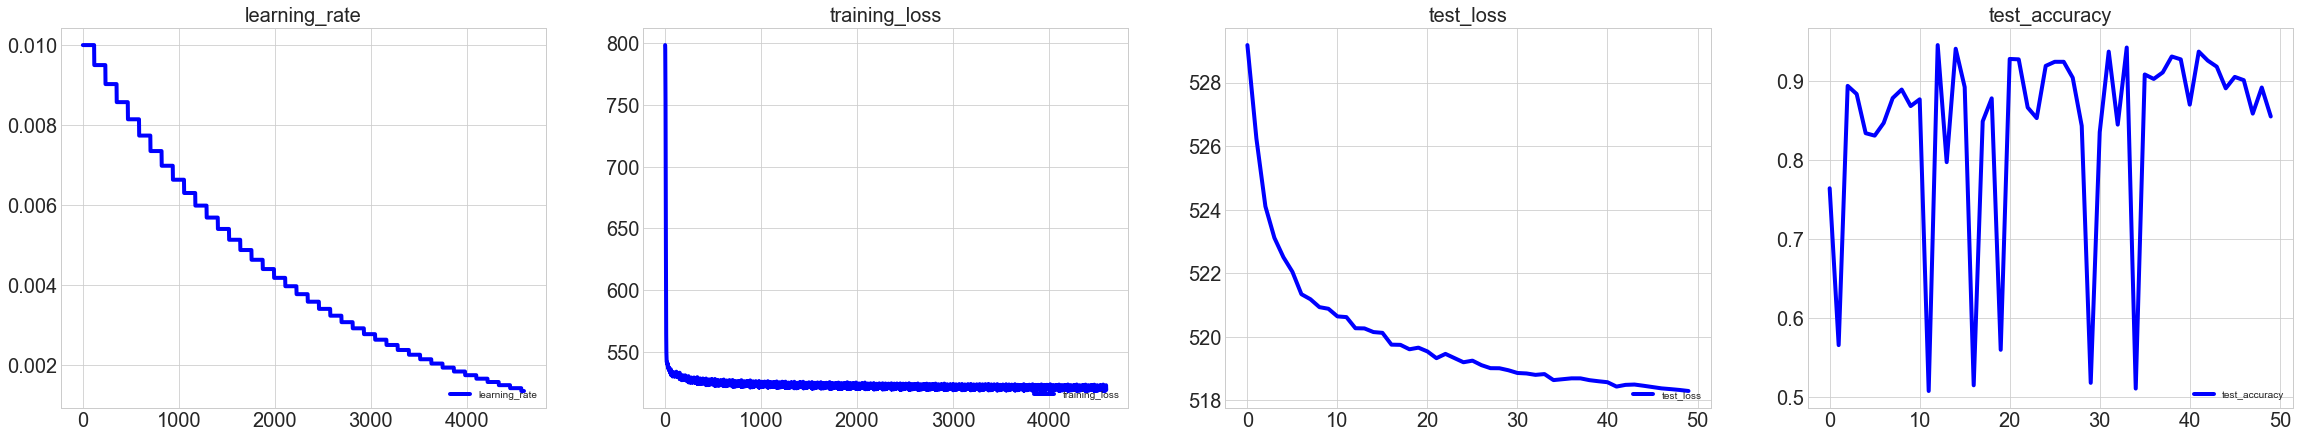

In [5]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))

l_rate_df = pd.DataFrame(learning_rate, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'learning_rate'})

l_rate_df = pd.DataFrame(training_loss, columns=['training_loss'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'training_loss'})

tr_loss_df = pd.DataFrame(test_loss, columns=['test_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_loss'})

cv_loss_df = pd.DataFrame(test_accuracy, columns=['test_accuracy'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_accuracy'})

## MODEL 5: MODEL 3 but leanring_rate = 0.005

In [4]:
epochs = 50
batch_size = 128
training_loss, test_loss, test_accuracy, learning_rate = RUN(epochs, batch_size,x_train, x_test, y_test)

X1:  (?, 256)
X1:  (?, 128)
z_mean:  (?, 32)
z_log_var:  (?, 32)
latent encoder:  (?, 32)
latent decoder:  (?, 128)
latent decoder:  (?, 256)
X_decoded_mean:  (?, 784)
input_shape (?, 784)
12121212121212 ()
Learning Rate: Initial:  0.005
EPOCH = 0, Avg Train Loss = 566.42353091, Test Loss = 528.333, Cluster_accuracy = 0.884575569358
EPOCH = 10, Avg Train Loss = 521.007557745, Test Loss = 518.611, Cluster_accuracy = 0.951863354037
EPOCH = 20, Avg Train Loss = 519.795940897, Test Loss = 517.672, Cluster_accuracy = 0.953933747412
EPOCH = 30, Avg Train Loss = 519.170643682, Test Loss = 517.283, Cluster_accuracy = 0.958592132505
EPOCH = 40, Avg Train Loss = 518.752377717, Test Loss = 517.076, Cluster_accuracy = 0.945134575569


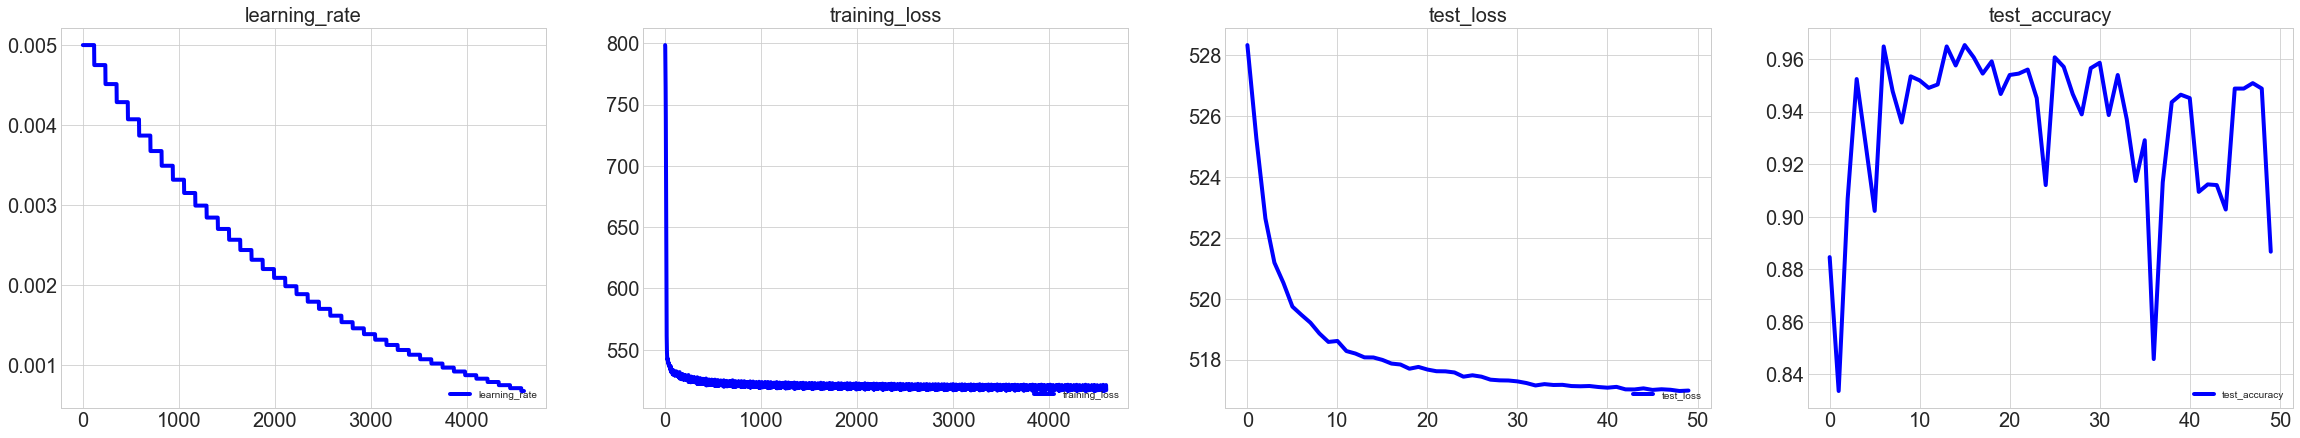

In [5]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))

l_rate_df = pd.DataFrame(learning_rate, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'learning_rate'})

l_rate_df = pd.DataFrame(training_loss, columns=['training_loss'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'training_loss'})

tr_loss_df = pd.DataFrame(test_loss, columns=['test_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_loss'})

cv_loss_df = pd.DataFrame(test_accuracy, columns=['test_accuracy'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'test_accuracy'})